In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [3]:
# calculate total duration of trip in miuntes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]

<AxesSubplot: xlabel='duration', ylabel='Count'>

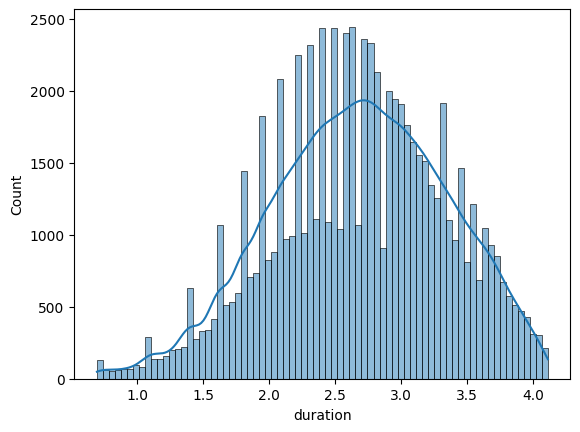

In [5]:
# plot log distribution of duration...
sns.histplot(np.log1p(df.duration), label='actual', kde = True)

In [6]:
# transform target variable to log scale
df.duration = np.log1p(df.duration)

In [7]:
# extract some features like weekday, hour and day..
df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour
df["pickup_day"] = df["lpep_pickup_datetime"].dt.day
df["pickup_weekday"] = df["lpep_pickup_datetime"].dt.weekday

In [8]:
# decide categorical and numerical variables...
categorical = ["PULocationID", "DOLocationID", "pickup_weekday"]
numerical = ["trip_distance", "pickup_day", "pickup_hour"]
df[categorical] = df[categorical].astype(str)

In [9]:
# turn pandas dataframe to dictionay vectorizer
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
target = 'duration'
y_train = df[target].values

In [10]:
# predict using linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

0.5538898347464111

C:\Users\hp\AppData\Local\Temp\ipykernel_5956\972592612.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.expm1(y_pred), label='prediction')
C:\Users\hp\AppData\Local\Temp\ipykernel_5956\972592612.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.expm1(y_train), label='actual')


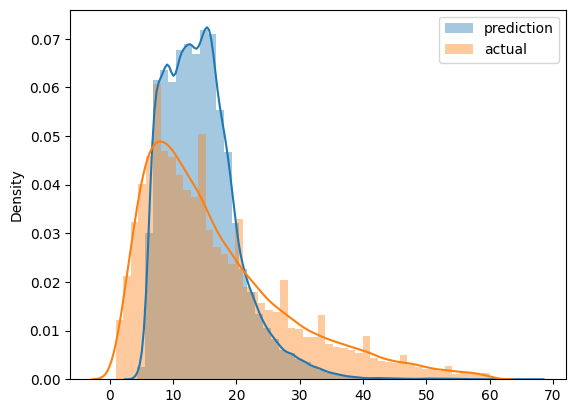

In [11]:
sns.distplot(np.expm1(y_pred), label='prediction')
sns.distplot(np.expm1(y_train), label='actual')
plt.legend()

In [12]:
mean_squared_error(np.expm1(y_train), np.expm1(y_pred), squared=False)

10.27879610663968

In [13]:
# function to do all the prev steps.
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df.duration = np.log1p(df.duration)
    df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour
    df["pickup_day"] = df["lpep_pickup_datetime"].dt.day
    df["pickup_weekday"] = df["lpep_pickup_datetime"].dt.weekday
    categorical = ['PULocationID', 'DOLocationID','pickup_weekday']
    df[categorical] = df[categorical].astype(str)
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False)

11.141115686617912

In [18]:
rlr = Ridge()
rlr.fit(X_train, y_train)
y_pred_r = rlr.predict(X_val)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred_r), squared=False)

11.105762729177659

In [19]:
with open("./models/linear_reg.bin", "wb") as model:
    pickle.dump((dv, lr), model)